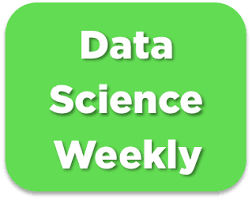

# Challenge : predict conversions

## Company's Description 📇

www.datascienceweekly.org is a famous newsletter curated by independent data scientists. Anyone can register his/her e-mail address on this website to receive weekly news about data science and its applications !

## Project 🚧

The data scientists who created the newsletter would like to understand better the behaviour of the users visiting their website. They would like to know if it's possible to build a model that predicts if a given user will subscribe to the newsletter, by using just a few information about the user. They would like to analyze the parameters of the model to highlight features that are important to explain the behaviour of the users, and maybe discover a new lever for action to improve the newsletter's conversion rate.

They designed a competition aiming at building a model that allows to predict the *conversions* (i.e. when a user will subscribe to the newsletter). To do so, they open-sourced a dataset containing some data about the traffic on their website. To assess the rankings of the different competing teams, they decided to use the **f1-score**.

## Goals 🎯

The project can be cut into four steps :

- Part 1 : make an EDA and the preprocessings and train a baseline model with the file *data_train.csv*
- Part 2 : improve your model's f1-score on your test set (you can try feature engineering, feature selection, regularization, non-linear models, hyperparameter optimization by grid search, etc...)
- Part 3 : Once you're satisfied with your model's score, you can use it to make some predictions with the file *data_test.csv*. You will have to dump the predictions into a .csv file that will be sent to Kaggle (actually, to your teacher/TA 🤓). You can make as many submissions as you want, feel free to try different models !
- Part 4 : Take some time to analyze your best model's parameters. Are there any lever for action that would help to improve the newsletter's conversion rate ? What recommendations would you make to the team ?

## Deliverable 📬

To complete this project, your team should:

- Create some relevant figures for EDA
- Train at least one model that predicts the conversions and evaluate its performances (f1, confusion matrices)
- Make at least one submission to the leaderboard 
- Analyze your best model's parameters and try to make some recommendations to improve the conversion rate in the future

### Import libraries

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix

warnings.filterwarnings("ignore")
sns.set()

### Import dataset

In [3]:
df = pd.read_csv("src/conversion_data_train.csv")
print(df.shape)
df.head()

(284580, 6)


,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


### Features explanation

- country: the country the user is from
- age: user's age
- new_user: is the user new or not
- source: user access type
- total_pages_visited: the number of visited pages
- converted: is the user converted or not

### EDA and data preprocessing

<Figure size 720x432 with 0 Axes>

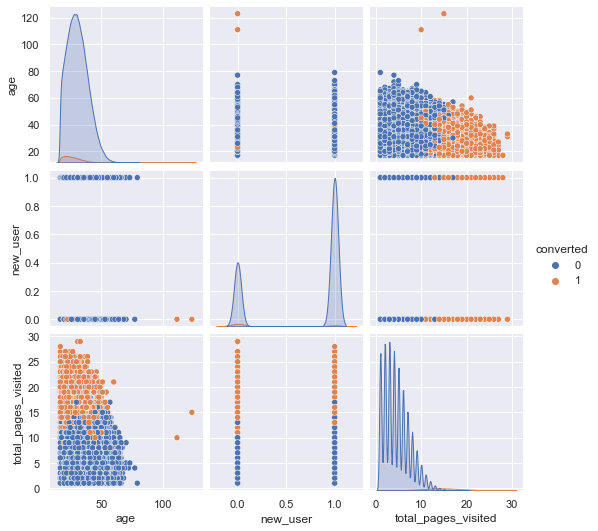

In [4]:
fig = plt.figure(1, figsize=(10, 6))
sns.pairplot(df, hue="converted")

- more converted when more *total_pages_visited*
- more converted when *new_user*

total_pages_visited    0.529192
new_user               0.152115
age                    0.088265
Name: converted, dtype: float64

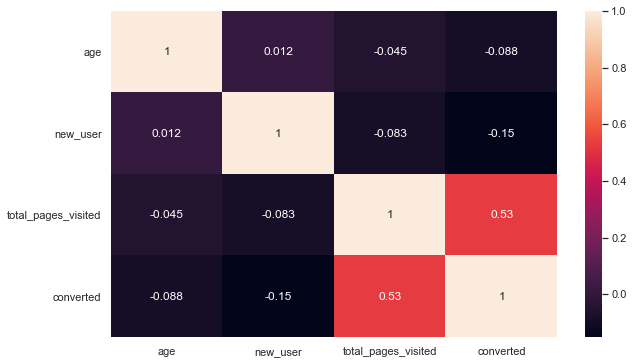

In [6]:
fig = plt.figure(1, figsize=(10, 6))
sns.heatmap(df.corr(), annot=True)
df.corr()["converted"].abs().sort_values(ascending=False).iloc[1:4]

In [7]:
print(100*df.isnull().sum()/df.shape[0])
df.describe(include="all")

country                0.0
age                    0.0
new_user               0.0
source                 0.0
total_pages_visited    0.0
converted              0.0
dtype: float64


,country,age,new_user,source,total_pages_visited,converted
count,284580,284580.000000,284580.000000,284580,284580.000000,284580.000000
unique,4,NaN,NaN,3,NaN,NaN
top,US,NaN,NaN,Seo,NaN,NaN
freq,160124,NaN,NaN,139477,NaN,NaN
mean,NaN,30.564203,0.685452,NaN,4.873252,0.032258
std,NaN,8.266789,0.464336,NaN,3.341995,0.176685
min,NaN,17.000000,0.000000,NaN,1.000000,0.000000
25%,NaN,24.000000,0.000000,NaN,2.000000,0.000000
50%,NaN,30.000000,1.000000,NaN,4.000000,0.000000
75%,NaN,36.000000,1.000000,NaN,7.000000,0.000000


In [8]:
# split X Y
features = ["country", "age", "new_user", "source", "total_pages_visited"]
target = ["converted"]

X = df.loc[:, features]
y = df.loc[:, target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

X

# random_state: to control the shuffling applied to the data before applying the split. Pass an int for reproducible output across multiple function calls.

,country,age,new_user,source,total_pages_visited
0,China,22,1,Direct,2
1,UK,21,1,Ads,3
2,Germany,20,0,Seo,14
3,US,23,1,Seo,3
4,US,28,1,Direct,3
...,...,...,...,...,...
284575,US,36,1,Ads,1
284576,US,31,1,Seo,2
284577,US,41,1,Seo,5
284578,US,31,1,Direct,4


In [9]:
# pipeline numeric & categorical

# age, total_pages_visited
numeric_features = [1, 4]
numeric_transformer = Pipeline(
    steps=[
        ("scaler", StandardScaler())
    ]
)

# country, new_user, source
categorical_features = [0, 2, 3]
categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(handle_unknown="ignore")) # drop="first"
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
        ("cat", categorical_transformer, categorical_features)
    ]
)

X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

X_train.shape

(227664, 11)

### Baseline model (logistic regression)

In [10]:
regressor = LogisticRegression()
regressor.fit(X_train, y_train)

y_train_pred = regressor.predict(X_train)
y_test_pred = regressor.predict(X_test)

print("F1-Score Train: %.5f" % (f1_score(y_train, y_train_pred)))
print("F1-Score Test: %.5f" % (f1_score(y_test, y_test_pred)))
print("Difference Train/Test: %.2f%%" % ((f1_score(y_train, y_train_pred)-f1_score(y_test, y_test_pred)) * 100))

F1-Score Train: 0.76526
F1-Score Test: 0.75806
Difference Train/Test: 0.72%


#### **Logistic Regression**

*Equation:*
$$Y = \mathbb{sigmoid}(X) = \frac{1}{1+\mathbb{exp}(-X)}$$
and
$$X = \beta_{0}+X_{1}\beta_{1}+...+X_{p}\beta_{p}$$

> $Y$ = target variable<br>
> $X_1$ = features<br>
> $\beta_0$ =  constant, where your line will start if $\beta_{1}$=0<br>
> $\beta_{1}$ = coefficient, represents the slope or weight of your variables<br>
> $\epsilon$ = residual, all the information that is not explained by the model

*Cost Function:*
$$Log Loss = \sum_{i=0}^n -y_ilog(\hat{y_i}) - (1-y_i)log(1-\hat{y_i})$$

> - Log Loss: make sure the algorithm predictions get closer to the actual target value<br>
> $y_i$ is your actual target value<br>
> $\hat{y_i}$ is your model's prediction<br>

*Evaluation:*
$$F1 score = \frac{Precision + Recall}{Precision \times Recall}$$
and
$$Precision = \frac{TP}{TP+FP}$$
and
$$Recall = \frac{TP}{TP+FN}$$

> - F1-score measure the performance of the model between classes<br>
> - Harmonic mean between the recall and the precision for a given class of the target variable<br>
> - The higher the value, the more the errors are uniformly well distributed in the classes<br>

### Improving our baseline?

In [11]:
def baseline(outliers=False, stratify=False):
    data = pd.read_csv("src/conversion_data_train.csv")
    
    # EDA and data preprocessing
    if outliers:
        # drop lines containing invalid values or outliers [Xˉ−3σ, Xˉ+3σ]
        mask = (data["age"] < data["age"].mean() + 3*data["age"].std()) & (data["age"] > data["age"].mean() - 3*data["age"].std())
        data = data.loc[mask, :]
    
    # split X Y
    features = ["country", "age", "new_user", "source", "total_pages_visited"]
    target = ["converted"]
    
    X = data.loc[:, features]
    y = data.loc[:, target]
    
    if stratify:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    else:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
    
    X_train = X_train.values
    X_test = X_test.values
    y_train = y_train.values
    y_test = y_test.values
    
    # pipeline numeric & categorical
    numeric_features = [1, 4]
    numeric_transformer = Pipeline(
        steps=[
            ("scaler", StandardScaler())
        ]
    )
    categorical_features = [0, 2, 3]
    categorical_transformer = Pipeline(
        steps=[
            ("encoder", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    
    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features)
        ]
    )
    
    X_train = preprocessor.fit_transform(X_train)
    X_test = preprocessor.transform(X_test)
    
    # baseline model (logistic regression)
    regressor = LogisticRegression()
    regressor.fit(X_train, y_train)
    
    y_train_pred = regressor.predict(X_train)
    y_test_pred = regressor.predict(X_test)
    
    print("F1-Score Train: %.5f" % (f1_score(y_train, y_train_pred)))
    print("F1-Score Test: %.5f" % (f1_score(y_test, y_test_pred)))
    print("Difference Train/Test: %.2f%%" % ((f1_score(y_train, y_train_pred)-f1_score(y_test, y_test_pred)) * 100))
    print()

In [12]:
baseline()
baseline(False, True)
baseline(True, False)
baseline(True, True)

F1-Score Train: 0.76526
F1-Score Test: 0.75806
Difference Train/Test: 0.72%

F1-Score Train: 0.76620
F1-Score Test: 0.75452
Difference Train/Test: 1.17%

F1-Score Train: 0.76606
F1-Score Test: 0.75510
Difference Train/Test: 1.10%

F1-Score Train: 0.76518
F1-Score Test: 0.75725
Difference Train/Test: 0.79%



- not relevant, our baseline is better when *outlier* and *stratify* option are false

Numerical columns are:  Index(['age', 'total_pages_visited'], dtype='object')
Categorical columns are:  [array(['China', 'Germany', 'UK', 'US'], dtype=object), array([0, 1], dtype=object), array(['Ads', 'Direct', 'Seo'], dtype=object)]
All columns name are:  ['age' 'total_pages_visited' 'China' 'Germany' 'UK' 'US' 0 1 'Ads'
 'Direct' 'Seo']


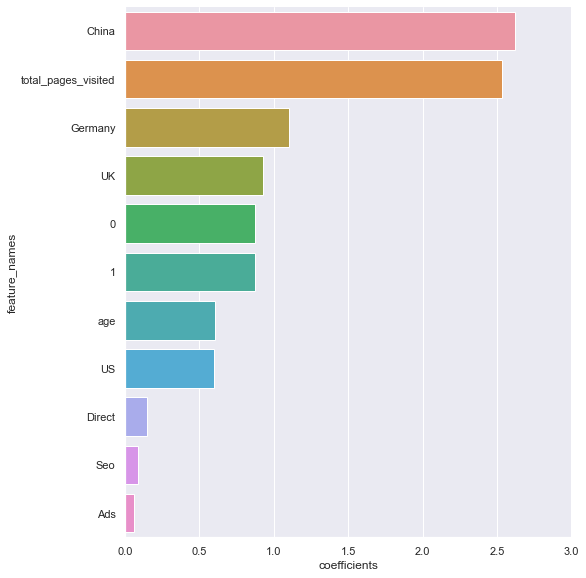

In [13]:
# values of the model's coefficients

# .columns attribute gives us the name of the column
numerical_column_names = X.iloc[:, numeric_features].columns
print("Numerical columns are: ", numerical_column_names)

# access one specific transformer from feature_encoder and print categories
categorical_column_names = preprocessor.transformers_[1][1][0].categories_
print("Categorical columns are: ", categorical_column_names)

# append all columns
all_column_names = np.append(numerical_column_names, categorical_column_names[0])
all_column_names = np.append(all_column_names, categorical_column_names[1])
all_column_names = np.append(all_column_names, categorical_column_names[2])
print("All columns name are: ", all_column_names)

# feature importance
feature_importance = pd.DataFrame(
    {
        "feature_names": all_column_names,
        "coefficients": regressor.coef_.squeeze()
    }
)

# set coefficient to absolute values to rank features
feature_importance["coefficients"] = feature_importance["coefficients"].abs()

# visualize ranked features using seaborn
sns.catplot(
    x="coefficients",
    y="feature_names",
    data=feature_importance.sort_values(by="coefficients", ascending=False),
    kind="bar",
    aspect=1,
    height=8).set_xticklabels(rotation=0);

### Improve model's f1-score

In [14]:
params_tree = {
    "max_depth": [4, 6, 8, 10],
    "min_samples_leaf": [1, 2, 5],
    "min_samples_split": [2, 4, 8]
}

params_forest = {
    "n_estimators": range(20, 50)
}

params_boost = {
    "n_estimators": [50, 100, 150, 200],
    "learning_rate": [1.0, 0.5, 0.1]
}

model_logistic = [
    {"Logistic Regression": LogisticRegression()},
]

model_tree_forest = [
    {"Decision Tree": DecisionTreeClassifier()},
    {"Decision Tree Grid": GridSearchCV(DecisionTreeClassifier(), param_grid=params_tree, cv=3)},
    {"Random Forest": GridSearchCV(RandomForestClassifier(), param_grid=params_forest, cv=3)}
]

model_boost = [
    {"Ada Boost": AdaBoostClassifier()},
    {"XGB": XGBClassifier(max_depth=3)},
    {"XGB Grid": GridSearchCV(XGBClassifier(), param_grid=params_boost, cv=3)}
]

def model_fit(X_train, X_test, y_train, y_test, model, title):
    %time model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    print(title)
    print("F1-Score Train: %.5f" % (f1_score(y_train, y_train_pred)))
    print("F1-Score Test: %.5f" % (f1_score(y_test, y_test_pred)))
    print("Difference Train/Test: %.2f%%" % ((f1_score(y_train, y_train_pred)-f1_score(y_test, y_test_pred)) * 100))
    print()
    
    return y_train_pred, y_test_pred

def evaluate(y_train, y_test, y_train_pred, y_test_pred, title):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))
    fig.suptitle(title)
    
    axes[0].set(title="Confusion Matrix on Train set")
    sns.heatmap(
        data=confusion_matrix(y_train, y_train_pred, normalize="true"),
        cmap="YlGnBu",
        annot=True,
        square=True,
        ax=axes[0]
    )
    
    axes[1].set(title="Confusion Matrix on Test set")
    sns.heatmap(
        data=confusion_matrix(y_test, y_test_pred, normalize="true"),
        cmap="YlGnBu",
        annot=True,
        square=True,
        ax=axes[1]
    )

Wall time: 1.39 s
Logistic Regression
F1-Score Train: 0.76526
F1-Score Test: 0.75806
Difference Train/Test: 0.72%



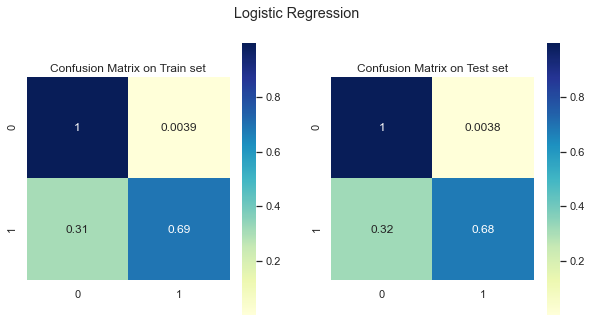

In [15]:
for count, elt in enumerate(model_logistic):
    title = list(elt.keys())[0]
    model = list(elt.values())[0]
    
    y_train_pred, y_test_pred = model_fit(X_train, X_test, y_train, y_test, model, title)
    evaluate(y_train, y_test, y_train_pred, y_test_pred, title)

Wall time: 847 ms
Decision Tree
F1-Score Train: 0.80095
F1-Score Test: 0.72755
Difference Train/Test: 7.34%

Wall time: 56 s
Decision Tree Grid
F1-Score Train: 0.76435
F1-Score Test: 0.75187
Difference Train/Test: 1.25%

Wall time: 7min 55s
Random Forest
F1-Score Train: 0.80543
F1-Score Test: 0.73822
Difference Train/Test: 6.72%



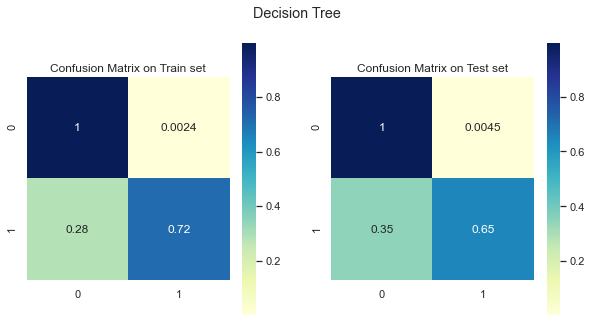

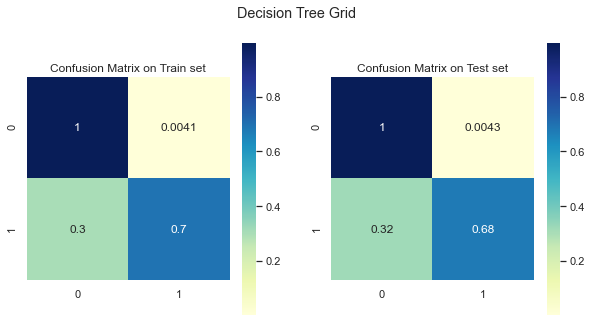

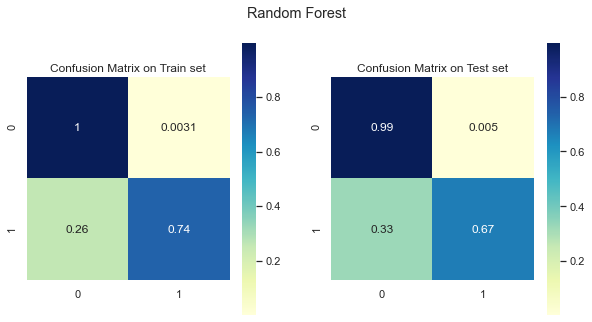

In [16]:
for count, elt in enumerate(model_tree_forest):
    title = list(elt.keys())[0]
    model = list(elt.values())[0]
    
    if count == len(model_tree_forest)-1:
        y_train_forest = np.squeeze(y_train)
        y_train_pred, y_test_pred = model_fit(X_train, X_test, y_train_forest, y_test, model, title)
    else:
        y_train_pred, y_test_pred = model_fit(X_train, X_test, y_train, y_test, model, title)
    
    evaluate(y_train, y_test, y_train_pred, y_test_pred, title)

Wall time: 10.3 s
Ada Boost
F1-Score Train: 0.75652
F1-Score Test: 0.75522
Difference Train/Test: 0.13%

[10:25:59] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Wall time: 5.6 s
XGB
F1-Score Train: 0.76586
F1-Score Test: 0.75557
Difference Train/Test: 1.03%

[10:26:05] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:26:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the obje

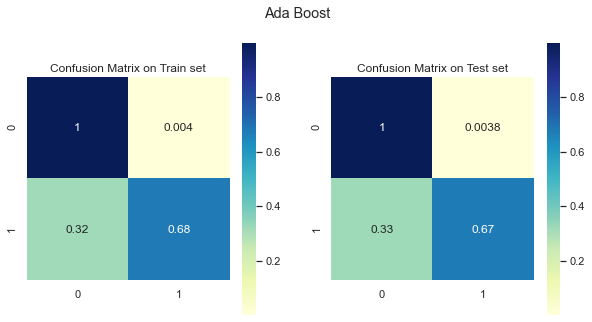

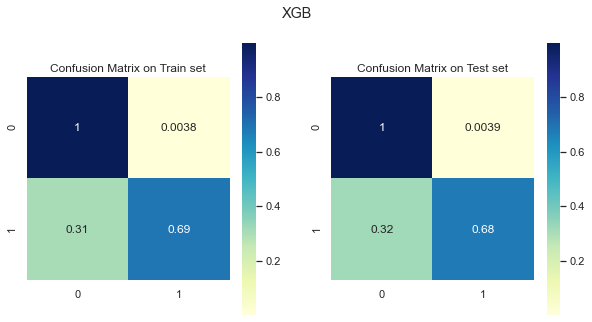

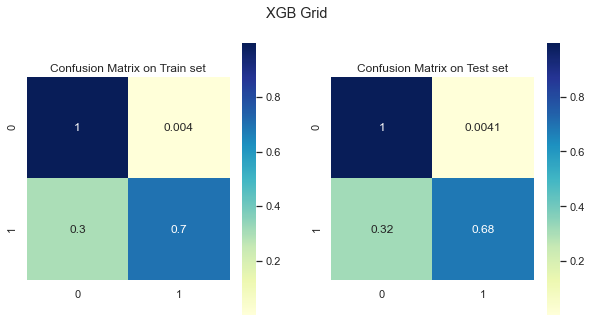

In [17]:
for count, elt in enumerate(model_boost):
    title = list(elt.keys())[0]
    model = list(elt.values())[0]
    
    y_train_pred, y_test_pred = model_fit(X_train, X_test, y_train, y_test, model, title)
    evaluate(y_train, y_test, y_train_pred, y_test_pred, title)

#### **Decision Tree**

> - Model that divide the dataset successively to produce the prediction<br>
> - At each division step, the model selects the variable and the threshold value which allow to obtain the two sub dataset in which the target variable will be as homogeneous as possible<br>
> - The model stop dividing the dataset when all branches contain sub datasets in which the target variable is homogeneous (the same value for all observations)<br>
> - The objectif is to minimize the sum of the heterogeneity of the branches and play with stopping criteria to achieve optimal bias/variance compromise<br>

*Equation:*
$$H_k=\sum_{i=1}^{m}p_{k}^{i}\cdot(1-p_{k}^{i})$$

> $m$ categories numbered from 1 to $m$<br>
> $p_{k}^{i}$ proportion of the class $i$ of $Y$ in the $k$ node<br>

*Stopping criteria:*

> - min_samples_leaf: minimum observation in a leaf<br>
> - min_samples_split: minimum number of leaf we must have before doing a division<br>
> - max_depth: maximum number of divisions that we can do from the root to the leaf<br>

#### **Random Forest**

> - A set of random trees gathered by bagging<br>

*Bagging:*

> - Bootstrap + Aggregating, involves training several models to solve the same prediction problem and combining their strengths to improve results<br>

*Bootstrap:*

> - Randomly generate various datasets, which resemble the original data, without being identical to them (training of models on varied data)<br>

*Parameter:*

> - n_estimators: number of trees in the forest<br>

#### **Ada Boost/XGBoost**

*Boosting:*

> 1. Starts by training the model on the training data<br>
> 2. Calculates predictions for each observation
> 3. Assign weights to each observation according to the prediction errors made (higher weight for error observations and for correct predictions)<br>
> 4. The model is trained again on previous data etc...<br>

*Gradient Boosting:*

> 1. The 1st model is train to predict the target<br>
> 2. Other models are train on the residuals from last model in the sequence<br>
> 3. Try to predict error from the previous model<br>

*Parameter:*

> - n_estimators: maximum number of estimators at which boosting is terminated<br>
> - learning_rate: controls the speed at which the weight of the observations is varied<br>

# Train best classifier on all data and use it to make predictions on X_without_labels

**Before making predictions on the file conversion_data_test.csv, let's train our model on ALL the data that was in conversion_data_train.csv. Sometimes, this allows to make tiny improvements in the score because we're using more examples to train the model.**

In [15]:
# concatenate our train and test set to train your best classifier on all data with labels
X = np.append(X_train, X_test, axis=0)
Y = np.append(y_train, y_test)

regressor.fit(X, Y)

LogisticRegression()

In [16]:
# read data without labels
data_without_labels = pd.read_csv("src/conversion_data_test.csv")
print("Prediction set (without labels) :", data_without_labels.shape)

X_without_labels = data_without_labels.loc[:, features]

# convert pandas DataFrames to numpy arrays before using scikit-learn
print("Convert pandas DataFrames to numpy arrays...")
X_without_labels = X_without_labels.values
print("...Done")
print(X_without_labels[0:5,:])

Prediction set (without labels) : (31620, 5)
Convert pandas DataFrames to numpy arrays...
...Done
[['UK' 28 0 'Seo' 16]
 ['UK' 22 1 'Direct' 5]
 ['China' 32 1 'Seo' 1]
 ['US' 32 1 'Ads' 6]
 ['China' 25 0 'Seo' 3]]


In [17]:
print("Encoding categorical features and standardizing numerical features...")
X_without_labels = preprocessor.transform(X_without_labels)
print("...Done")
print(X_without_labels[0:5,:])

Encoding categorical features and standardizing numerical features...
...Done
[[-0.3112874   3.32677112  0.          0.          1.          0.
   1.          0.          0.          0.          1.        ]
 [-1.03716308  0.03803388  0.          0.          1.          0.
   0.          1.          0.          1.          0.        ]
 [ 0.17262971 -1.15787057  1.          0.          0.          0.
   0.          1.          0.          0.          1.        ]
 [ 0.17262971  0.33701     0.          0.          0.          1.
   0.          1.          1.          0.          0.        ]
 [-0.67422524 -0.55991834  1.          0.          0.          0.
   1.          0.          0.          0.          1.        ]]


In [18]:
# make predictions and dump to file
data = {
    "converted": regressor.predict(X_without_labels)
}

Y_predictions = pd.DataFrame(columns=["converted"], data=data)
Y_predictions.to_csv("src/conversion_data_test_predictions_JULES-LogisticRegression.csv", index=False)